In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, precision_score, recall_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

LOAD PREPROCESSED DATA

In [8]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Fraud cases in training: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.2f}%)")


Training samples: 227845
Test samples: 56962
Number of features: 30
Fraud cases in training: 394 (0.17%)


BUILD MLP MODEL

In [9]:
def create_mlp_model(input_dim):
    """
    Creates a Multi-Layer Perceptron with:
    - 4 hidden layers with decreasing neurons
    - Batch normalization for training stability
    - Dropout for regularization
    - ReLU activation for hidden layers
    - Sigmoid activation for binary classification
    """
    model = Sequential([
        # Input layer
        Dense(128, activation='relu', input_dim=input_dim, name='input_layer'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Hidden layer 1
        Dense(64, activation='relu', name='hidden_layer_1'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Hidden layer 2
        Dense(32, activation='relu', name='hidden_layer_2'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Hidden layer 3
        Dense(16, activation='relu', name='hidden_layer_3'),
        Dropout(0.2),
        
        # Output layer
        Dense(1, activation='sigmoid', name='output_layer')
    ])
    
    return model

In [10]:
# Create model
model = create_mlp_model(X_train.shape[1])

# Display model architecture
print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (Dense)                  │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_1 (Dense)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_2 (Dense)               │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_3 (Dense)               │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,745 (61.50 KB)

 Trainable params: 15,297 (59.75 KB)

 Non-trainable params: 448 (1.75 KB)

COMPILE MODEL

In [11]:
# Calculate class weights to handle imbalance
neg_count = len(y_train) - y_train.sum()
pos_count = y_train.sum()
total = len(y_train)

weight_for_0 = (1 / neg_count) * (total / 2.0)
weight_for_1 = (1 / pos_count) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"\nClass weights:")
print(f"Normal transactions (0): {weight_for_0:.4f}")
print(f"Fraud transactions (1): {weight_for_1:.4f}")


Class weights:
Normal transactions (0): 0.5009
Fraud transactions (1): 289.1434


In [12]:
# Compile with appropriate loss and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

SETUP CALLBACKS

In [13]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [14]:
# Save best model
checkpoint = ModelCheckpoint(
    'mlp_best_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

TRAIN MODEL

In [15]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8827 - auc: 0.9208 - loss: 0.3261 - precision: 0.0129 - recall: 0.8354
Epoch 1: val_auc improved from None to 0.98440, saving model to mlp_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9063 - auc: 0.9432 - loss: 0.2786 - precision: 0.0157 - recall: 0.8714 - val_accuracy: 0.9544 - val_auc: 0.9844 - val_loss: 0.1804 - val_precision: 0.0354 - val_recall: 0.9157 - learning_rate: 0.0010
Epoch 2/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9334 - auc: 0.9770 - loss: 0.1837 - precision: 0.0245 - recall: 0.9362
Epoch 2: val_auc improved from 0.98440 to 0.98452, saving model to mlp_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9359 - auc: 0.9659 - loss: 0.2179 - precision: 0.0234 - recall: 0.8971 - val_accuracy: 0.9600 - val_auc: 0.9845 - val_loss: 0.1388 - val_precision: 0.0406 - val_recall: 0.9277 - learning_rate: 0.0010
Epoch 3/50
711/713 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9362 - auc: 0.9841 - loss: 0.1537 - precision: 0.0260 - recall: 0.9559
Epoch 3: val_auc did not improve from 0.98452
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9409 - auc: 0.9795 - loss: 0.1747 - precision: 0.0259 - recall: 0.9164 - val_accuracy: 0.9591 - val_auc: 0.9828 - val_loss: 0.1144 - val_precision: 0.0403 - val_recall: 0.9398 - learning_rate: 0.0010
Epoch 4/50
704/713 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9444 - auc: 0.9856 - loss: 0.1380 - precision: 0.0296 - recall: 0.9537
Epoch 4: val_auc improved from 0.98452 to 0.98611, saving model to mlp_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9457 - auc: 0.9837 - loss: 0.1579 - precision: 0.0288 - recall: 0.9421 - val_accuracy: 0.9599 - val_auc: 0.9861 - val_loss: 0.1005 - val_precision: 0.0410 - val_recall: 0.9398 - learning_rate: 0.0010
Epoch 5/50
706/713 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9486 - auc: 0.9862 - loss: 0.1300 - precision: 0.0322 - recall: 0.9624
Epoch 5: val_auc did not improve from 0.98611
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9501 - auc: 0.9859 - loss: 0.1451 - precision: 0.0312 - recall: 0.9421 - val_accuracy: 0.9557 - val_auc: 0.9845 - val_loss: 0.0956 - val_precision: 0.0382 - val_recall: 0.9639 - learning_rate: 0.0010
Epoch 6/50
704/713 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9503 - auc: 0.9910 - loss: 0.1018 - precision: 0.0338 - recall: 0.9782
Epoch 6: val_auc improved from 0.98611 to 0.98820, saving model to mlp_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9520 - auc: 0.9894 - loss: 0.1245 - precision: 0.0328 - recall: 0.9518 - val_accuracy: 0.9716 - val_auc: 0.9882 - val_loss: 0.0723 - val_precision: 0.0571 - val_recall: 0.9398 - learning_rate: 0.0010
Epoch 7/50
704/713 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9554 - auc: 0.9895 - loss: 0.1095 - precision: 0.0370 - recall: 0.9644
Epoch 7: val_auc did not improve from 0.98820
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9546 - auc: 0.9899 - loss: 0.1237 - precision: 0.0342 - recall: 0.9421 - val_accuracy: 0.9842 - val_auc: 0.9856 - val_loss: 0.0593 - val_precision: 0.0952 - val_recall: 0.9036 - learning_rate: 0.0010
Epoch 8/50
706/713 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9637 - auc: 0.9906 - loss: 0.0929 - precision: 0.0455 - recall: 0.9710
Epoch 8: val_auc did not improve from 0.98820
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9642 - auc: 0.9905 - loss: 0.1136 - precision: 0.0434 - recall: 0.948

713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9558 - auc: 0.9926 - loss: 0.1085 - precision: 0.0352 - recall: 0.9453 - val_accuracy: 0.9709 - val_auc: 0.9883 - val_loss: 0.0611 - val_precision: 0.0564 - val_recall: 0.9518 - learning_rate: 0.0010
Epoch 11/50
706/713 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9574 - auc: 0.9933 - loss: 0.0818 - precision: 0.0388 - recall: 0.9681
Epoch 11: val_auc did not improve from 0.98832
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9554 - auc: 0.9938 - loss: 0.1004 - precision: 0.0355 - recall: 0.9614 - val_accuracy: 0.9695 - val_auc: 0.9857 - val_loss: 0.0670 - val_precision: 0.0521 - val_recall: 0.9157 - learning_rate: 0.0010
Epoch 12/50
707/713 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9602 - auc: 0.9934 - loss: 0.0791 - precision: 0.0417 - recall: 0.9686
Epoch 12: val_auc improved from 0.98832 to 0.98918, saving model to mlp_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9625 - auc: 0.9939 - loss: 0.0972 - precision: 0.0419 - recall: 0.9582 - val_accuracy: 0.9739 - val_auc: 0.9892 - val_loss: 0.0583 - val_precision: 0.0625 - val_recall: 0.9518 - learning_rate: 0.0010
Epoch 13/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9619 - auc: 0.9933 - loss: 0.0792 - precision: 0.0436 - recall: 0.9739
Epoch 13: val_auc did not improve from 0.98918
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9623 - auc: 0.9942 - loss: 0.0958 - precision: 0.0418 - recall: 0.9614 - val_accuracy: 0.9737 - val_auc: 0.9878 - val_loss: 0.0619 - val_precision: 0.0607 - val_recall: 0.9277 - learning_rate: 0.0010
Epoch 14/50
704/713 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9584 - auc: 0.9916 - loss: 0.0953 - precision: 0.0397 - recall: 0.9644
Epoch 14: val_auc did not improve from 0.98918
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9596 - auc: 0.9944 - loss: 0.0941 - precision: 0.0391 - recall: 0

PLOT TRAINING HISTORY

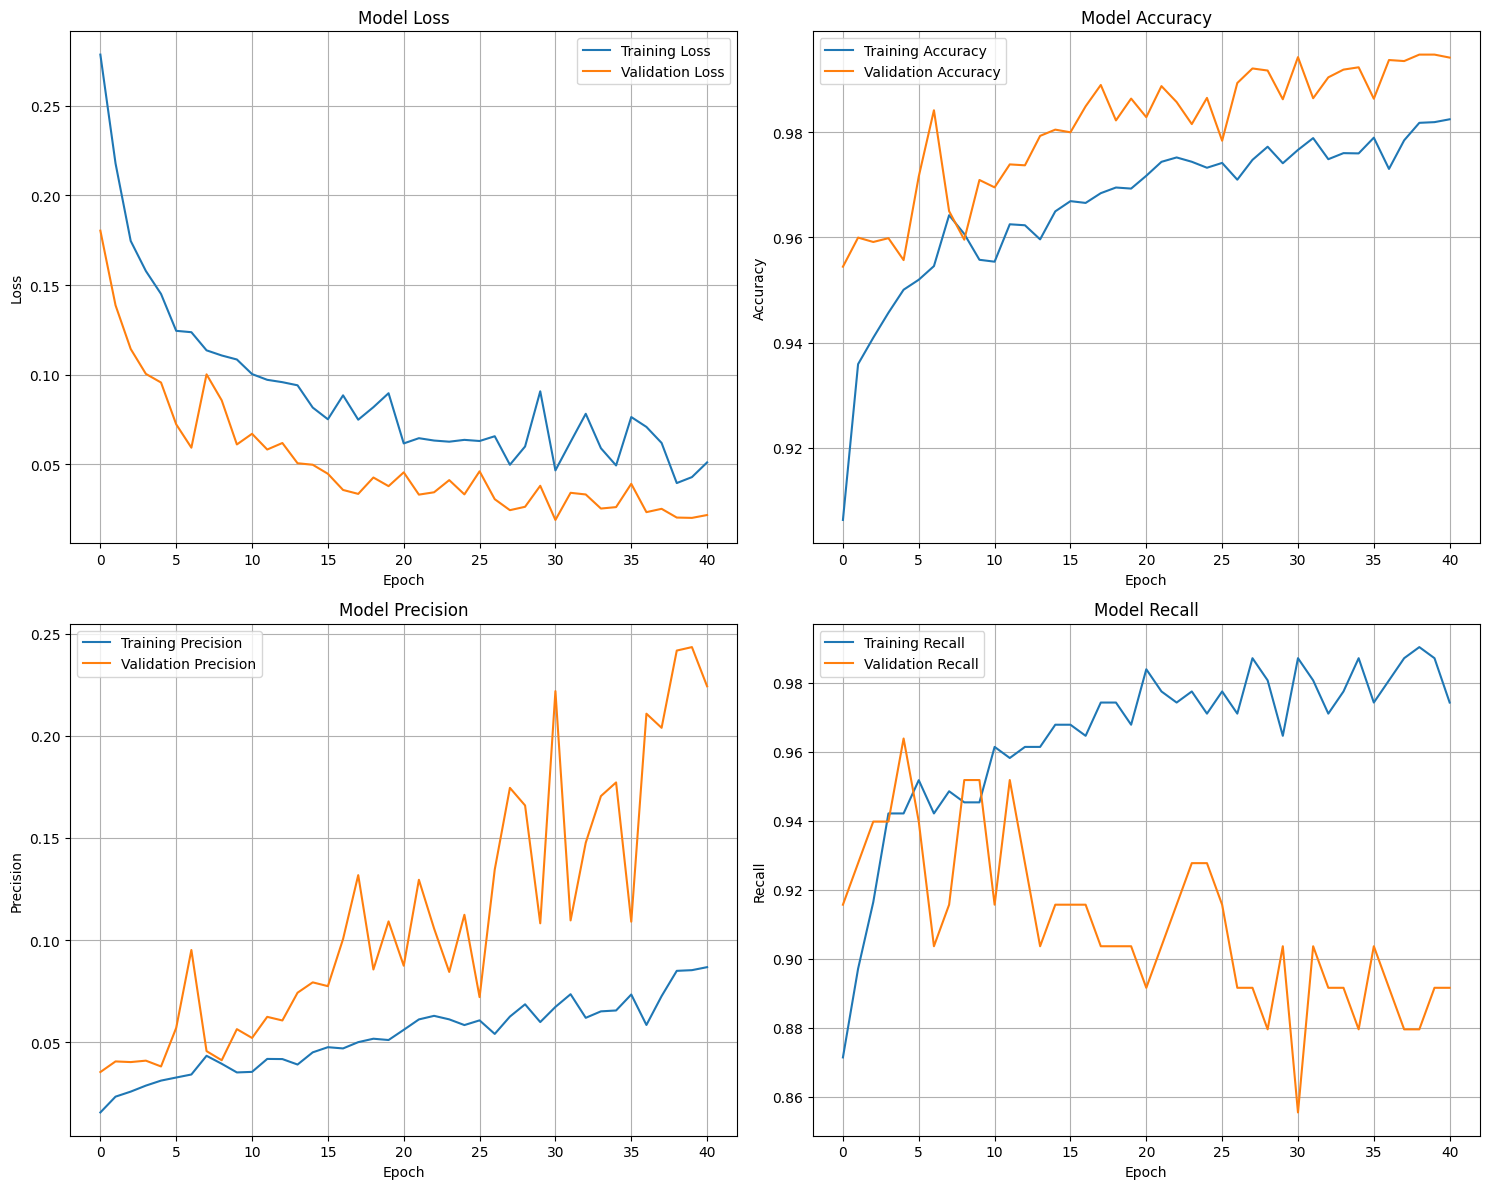

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('mlp_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

EVALUATE MODEL

In [17]:
# Predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nTest Set Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")


Test Set Performance:
Accuracy:  0.9938
Precision: 0.2019
Recall:    0.8878
F1-Score:  0.3289
ROC-AUC:   0.9676


In [18]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     56864
       Fraud       0.20      0.89      0.33        98

    accuracy                           0.99     56962
   macro avg       0.60      0.94      0.66     56962
weighted avg       1.00      0.99      1.00     56962



CONFUSION MATRIX

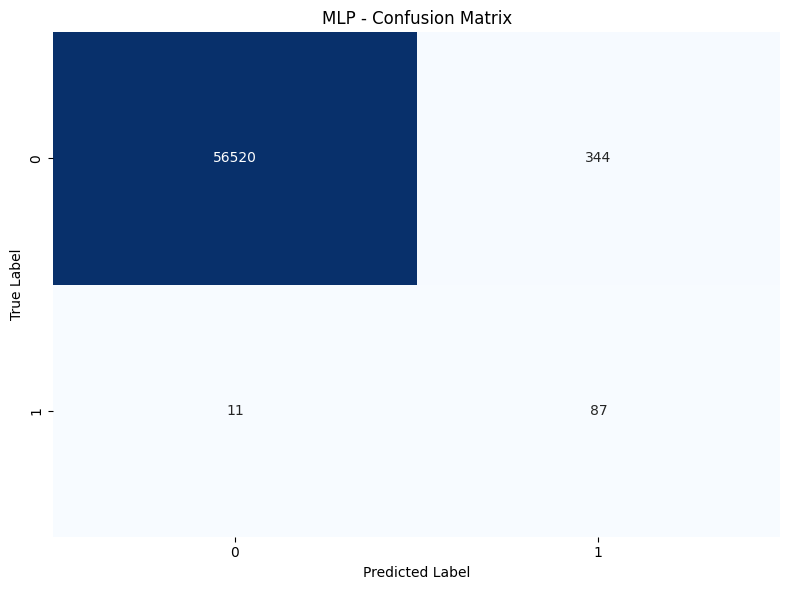

In [19]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('MLP - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('mlp_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

ROC CURVE

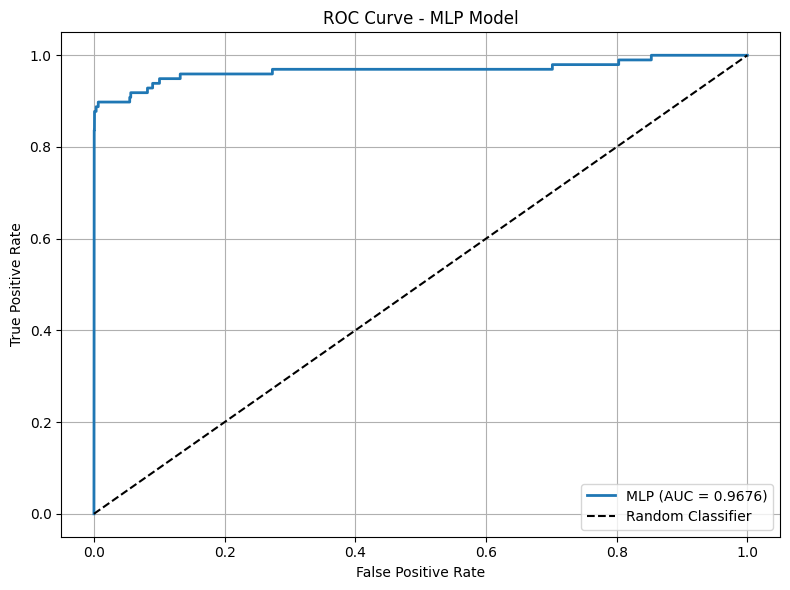

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mlp_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

PRECISION-RECALL CURVE

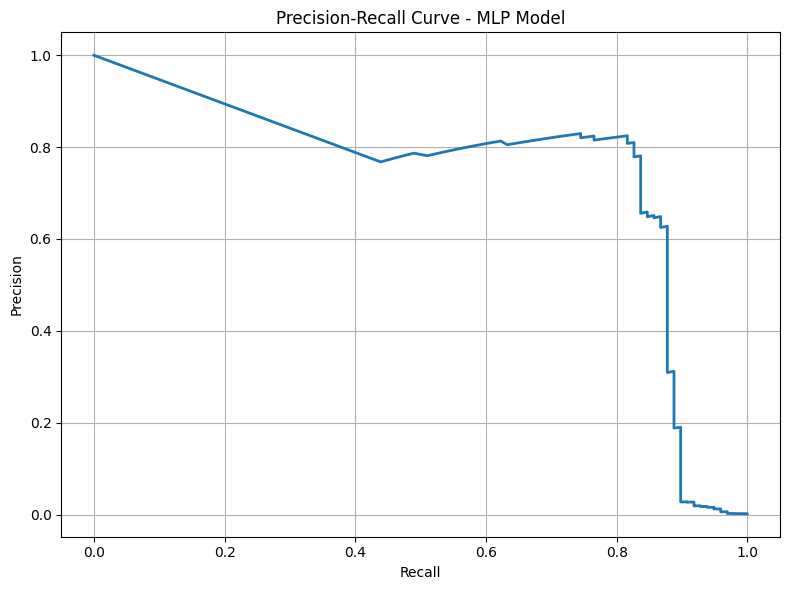

In [21]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - MLP Model')
plt.grid(True)
plt.tight_layout()
plt.savefig('mlp_precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

SAVE RESULTS

In [22]:
results = {
    'Model': 'Multi-Layer Perceptron',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC-AUC': auc
}

results_df = pd.DataFrame([results])
results_df.to_csv('mlp_results.csv', index=False)